## 1st Assginment
March 24, 2023

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import math

## Methods

In [4]:
def process(model,dataloader):
    spikes_data =None 
    for data in dataloader:
        result = model(data[0])
        if spikes_data is None:
            spikes_data = result
        else : 
            spikes_data = torch.vstack((spikes_data,result))
    return spikes_data

In [5]:
def plot_current(dataframe):
    fig = plt.figure(figsize=(8,5))
    plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,1],c='r')
    plt.xlabel("time (mS)")
    plt.ylabel("current(pA)")
    plt.grid()
    plt.title("current diagram")
    plt.show()

In [6]:
def plot_fl_curve(spikes):
    fr = np.zeros(10)
    print("Average Frequency: ", len(spikes[spikes[:,1]==1.0]))
    for i in range(10):
        sublst = spikes[i*3200:(i+1)*3200]
        fr[i] = len(sublst[sublst[:,1]==1.0])*10

    plt.plot(fr)
    plt.xlabel('I(t)')
    plt.ylabel('Frequency')

In [7]:
def plot_spikes(spikes):
    spike_points = spikes[spikes[:,1]==1.0]
    fig = plt.figure(figsize=(50,5))
    plt.scatter(spike_points[:,0],spike_points[:,1],marker='|',c='r', s=500)
    plt.xlabel("time (mS)")
    plt.yticks(ticks=[1],labels=['spike'])
    plt.grid()
    plt.title("Spike points diagram")
    plt.show()

In [8]:
def plot_voltage(history):
    fig = plt.figure(figsize=(50, 5))
    plt.plot(history[:,0],history[:,1],c='r')
    plt.xlabel("time (mS)")
    plt.ylabel("Voltage(mV)")
    plt.grid()
    plt.title("PSP diagram")
    plt.show()

In [9]:
class CurrentDataset(torch.utils.data.Dataset):

    def __init__(self,data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[idx].values
        return torch.tensor(sample)

## Building LIF(Leaky Intergrated and Fire) model

In [10]:
class LeakyIntegrateAndFire(torch.nn.Module):
    
    def __init__(self, resistance, tau, u_rest, threshold, time = 0):
        super(LeakyIntegrateAndFire, self).__init__()
    
        self.resistance = resistance
        self.tau = tau
        self.current_u = u_rest
        self.u_rest = u_rest
        self.threshold = threshold
        self.time = time
        self.history = torch.tensor([self.time, self.current_u])
    
    
    def forward(self, x):
        
        self.current_u += (-(self.current_u - self.u_rest) + self.resistance * x[1]) * (x[0] - self.time) / self.tau
        self.time = x[0]
        
        if self.current_u > self.threshold:
            self.to_rest()
            self.history = torch.vstack((self.history, torch.tensor([self.time, self.current_u])))
            return torch.tensor([[self.time, 1]])
        
        else : 
            self.history = torch.vstack((self.history, torch.tensor([self.time, self.current_u])))
            return torch.tensor([[self.time, 0]])
        
    def reset(self):
        self.time = 0
        self.current_u = self.u_rest
        self.history = torch.tensor([self.time, self.current_u])
        
    
    def to_rest(self):
        self.current_u = self.u_rest

In [11]:
model1 = LeakyIntegrateAndFire(resistance=0.01, tau=8, u_rest=-65, threshold=-55)
model2 = LeakyIntegrateAndFire(resistance=0.005, tau=8, u_rest=-65, threshold=-55)
model3 = LeakyIntegrateAndFire(resistance=0.01, tau=12, u_rest=-65, threshold=-55)
model4 = LeakyIntegrateAndFire(resistance=0.01, tau=8, u_rest=-70, threshold=-55)
model5 = LeakyIntegrateAndFire(resistance=0.01, tau=8, u_rest=-65, threshold=-50)

## Define currents 

In [12]:
timedelta = 1/32
timesteps =  [i * timedelta for i in range(32000)]
const_current = 100*[0] + 7000*[1000] + 7000*[2000] + 7000*[3000] + 7000*[4000] + 3900*[5000]
d = {'time': timesteps, 'current' : const_current}
const_df = pd.DataFrame(data=d)
const_current_dataset = CurrentDataset(const_df)
const_current_dataloader = torch.utils.data.DataLoader(const_current_dataset,batch_size=1,shuffle=False)

In [14]:
noisy = []
for _ in range(319):
    noisy += [random.randint(0, 5000)]*100
    
noisy_current = 100*[0] + noisy

d = {'time': timesteps, 'current' : noisy_current}
noisy_df = pd.DataFrame(data=d)
noisy_current_dataset = CurrentDataset(noisy_df)
noisy_current_dataloader = torch.utils.data.DataLoader(noisy_current_dataset,batch_size=1,shuffle=False)

## Step shaped current as input for different settings

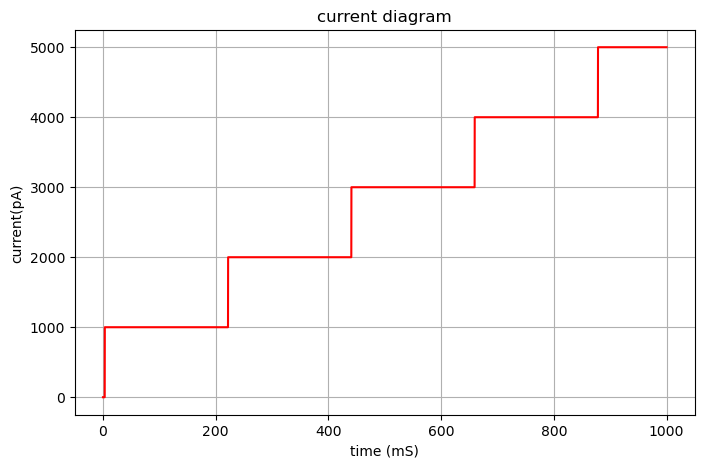

In [15]:
plot_current(const_df)

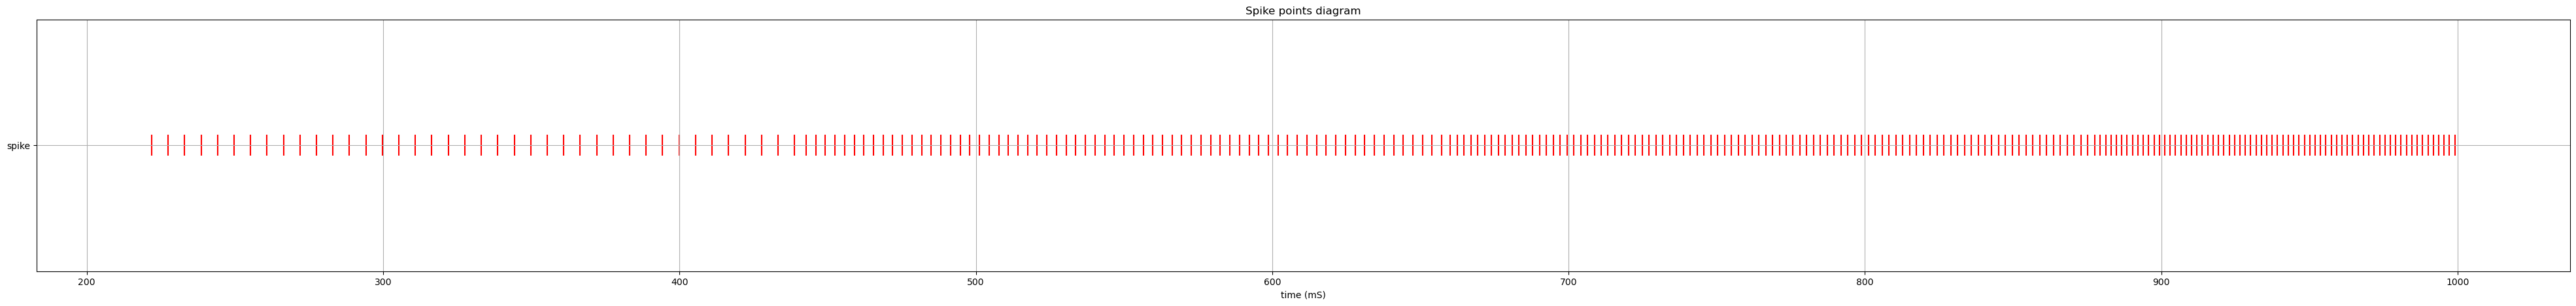

In [16]:
spikes_information = process(model1, const_current_dataloader)
plot_spikes(spikes_information)

Average Frequency:  269


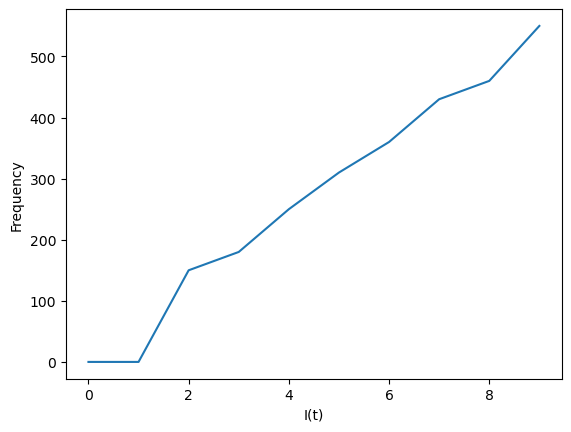

In [17]:
plot_fl_curve(spikes_information)

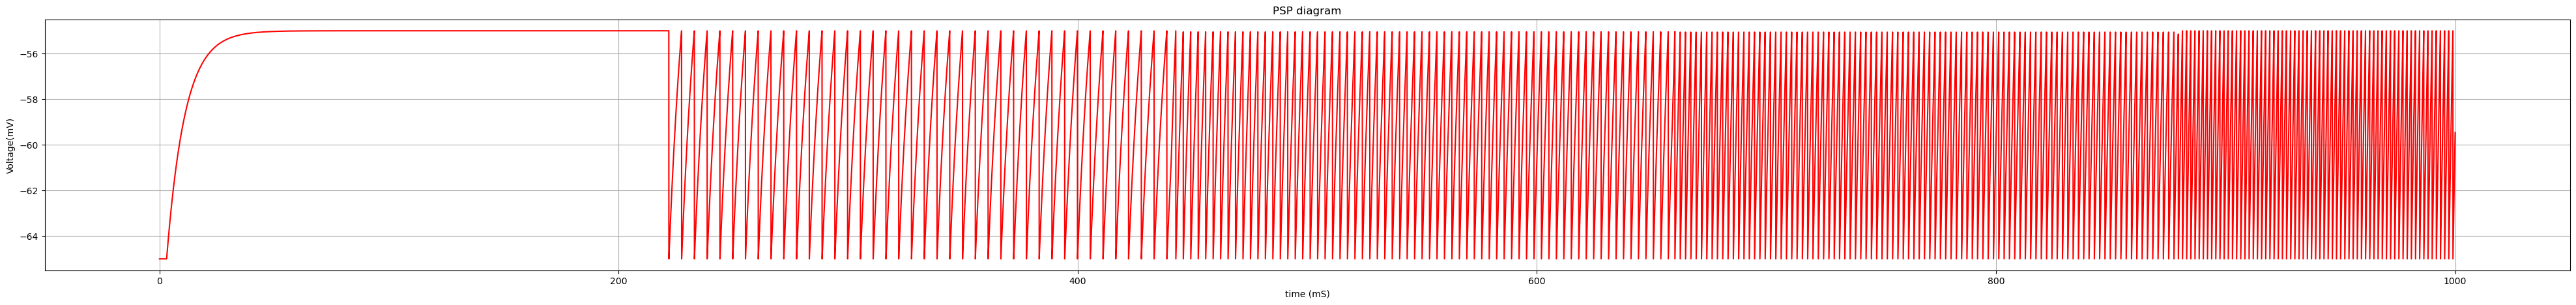

In [18]:
plot_voltage(model1.history)

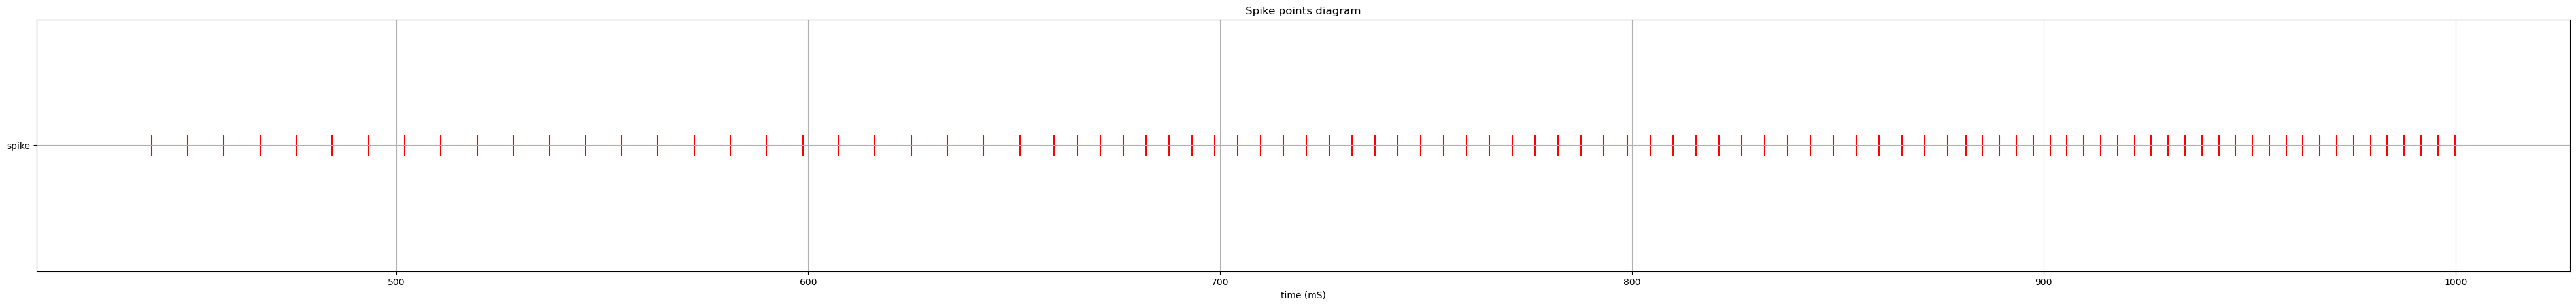

In [19]:
spikes_information = process(model2, const_current_dataloader)
plot_spikes(spikes_information)

Average Frequency:  95


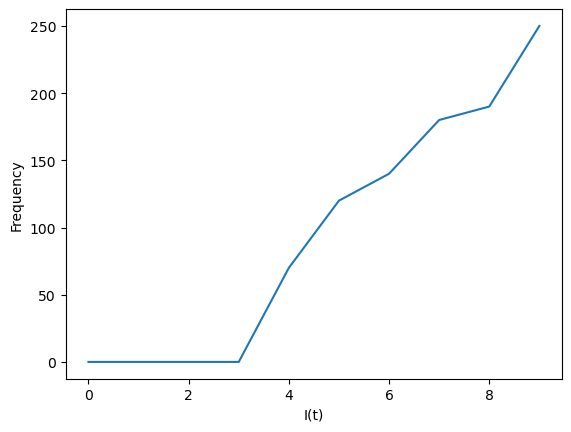

In [20]:
plot_fl_curve(spikes_information)

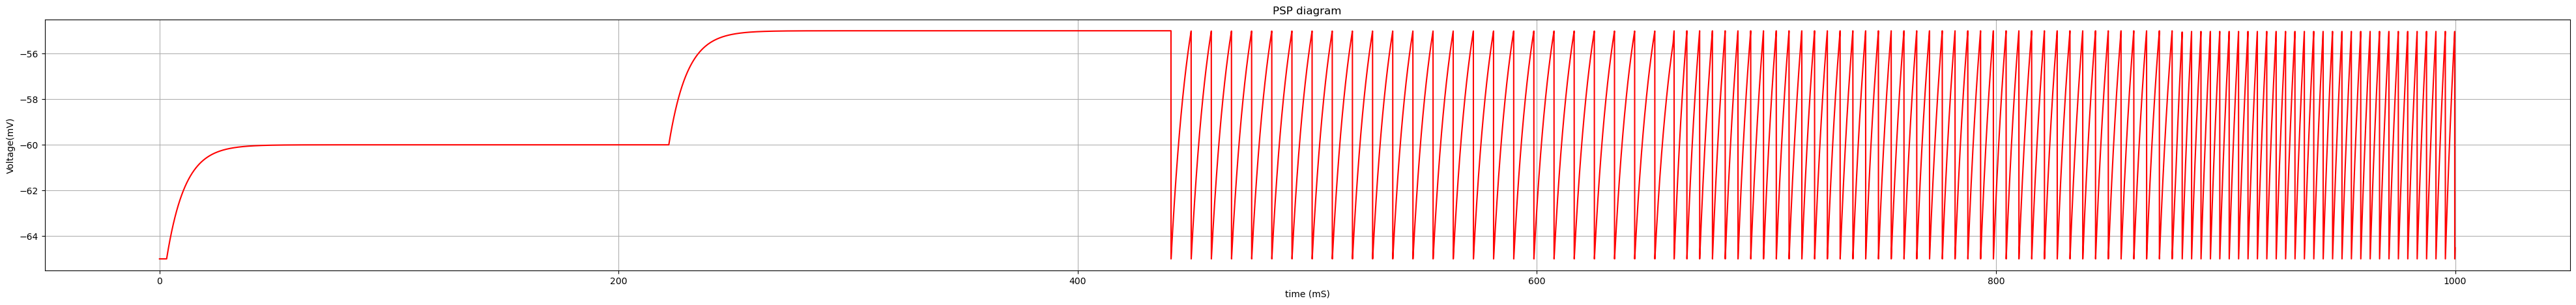

In [21]:
plot_voltage(model2.history)

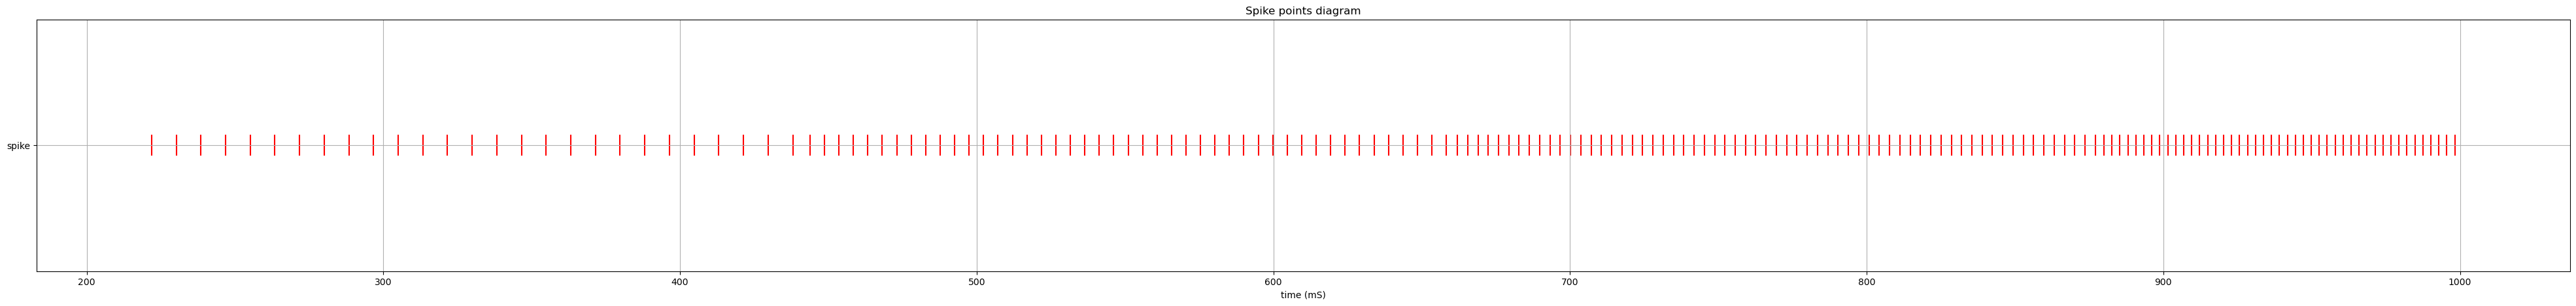

In [22]:
spikes_information = process(model3, const_current_dataloader)
plot_spikes(spikes_information)

Average Frequency:  180


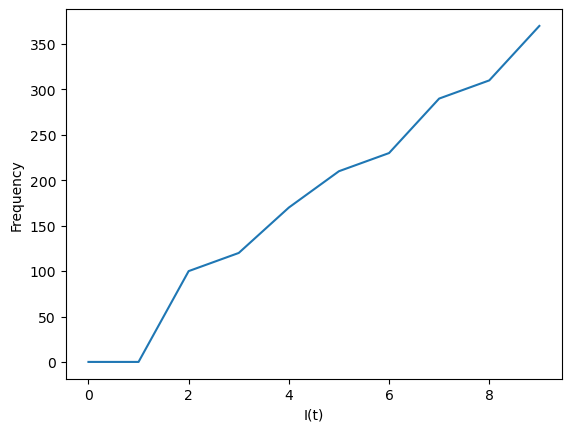

In [23]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model3.history)

In [ ]:
spikes_information = process(model4, const_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model4.history)

In [ ]:
spikes_information = process(model5, const_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model5.history)

In [ ]:
model1.reset()
model2.reset()
model3.reset()
model4.reset()
model5.reset()

## Noisy current as input for different settings

In [ ]:
plot_current(noisy_df)

In [ ]:
spikes_information = process(model1, noisy_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model1.history)

In [ ]:
spikes_information = process(model2, noisy_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model2.history)

In [ ]:
spikes_information = process(model3, noisy_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model3.history)

In [ ]:
spikes_information = process(model4, noisy_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model4.history)

In [ ]:
spikes_information = process(model5, noisy_current_dataloader)
plot_spikes(spikes_information)

In [ ]:
plot_fl_curve(spikes_information)

In [ ]:
plot_voltage(model5.history)